In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


## Load input data

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


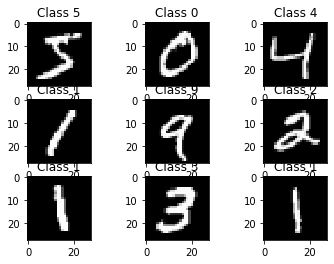

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Prepare data

In [4]:
#prepare correct data shape for Activation Maximization compatibility
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [5]:
all_data = np.append(X_test, X_train, axis=0)
all_onehot_labels = np.append(Y_test, Y_train, axis=0)
all_labels = np.append(y_test, y_train, axis=0)
print(all_data.shape)
print(all_onehot_labels.shape)
print(all_labels.shape)

(70000, 28, 28, 1)
(70000, 10)
(70000,)


## Create neural network

In [16]:
l1_neurons, l2_neurons = 64, 64
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())  # Activation Maximization needs the model to take in structured images, but our NN is fully connected
model.add(Dense(l1_neurons, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(l2_neurons, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='predictions'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4, verbose=1,
          validation_data=(X_test, Y_test))

C:\Users\prokopcerny\.conda\envs\VIZ\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 3s 52us/step - loss: 0.3228 - accuracy: 0.9000 - val_loss: 0.0666 - val_accuracy: 0.9784

In [19]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Test score: 0.03462153067991603
Test accuracy: 0.9890999794006348


In [20]:
up_to_first_dense_layer = Sequential()
up_to_first_dense_layer.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape, weights=model.layers[0].get_weights()))
up_to_first_dense_layer.add(Conv2D(32, kernel_size=(3,3), activation='relu', weights=model.layers[1].get_weights()))
up_to_first_dense_layer.add(MaxPooling2D(pool_size=(2,2)))
up_to_first_dense_layer.add(Dropout(0.2))
up_to_first_dense_layer.add(Flatten())
up_to_first_dense_layer.add(Dense(l1_neurons, weights=model.layers[5].get_weights(), activation='relu'))
#first_layer.add(Activation('relu'))

fc1_digit_activations = np.zeros((10, l1_neurons), dtype=np.float64)
for digit in range(10):
    fc1_digit_activations[digit] = np.average(up_to_first_dense_layer.predict(all_data[all_labels == digit]), axis=0)

print(np.average(up_to_first_dense_layer.predict(all_data[all_labels == 0]), axis=0).shape)

(64,)


In [21]:
fc1_digit_activations_normalized = fc1_digit_activations/np.max(fc1_digit_activations)

In [22]:
#prototype for saving data
# saves the first fully connected layer activations to a file
import json
from pathlib import Path
print(fc1_digit_activations[:, :5])
print(json.dumps(fc1_digit_activations[:, :8].tolist()))
with Path('./test.json').open(mode='w', newline='\n') as file:
    file.write(json.dumps(fc1_digit_activations.tolist()))
    file.write('\n')

[[4.38398262e-03 3.03690284e-02 2.14804220e+00 0.00000000e+00
  4.99460995e-02]
 [6.12270972e-03 5.11783501e-03 2.16088104e+00 0.00000000e+00
  1.43514285e-02]
 [3.51276770e-02 1.90988020e-03 1.32104820e-02 0.00000000e+00
  5.50755374e-02]
 [1.68577981e+00 6.23698393e-03 1.56691018e-02 0.00000000e+00
  3.85627826e-03]
 [3.04857325e-02 4.13009375e-02 3.73534672e-03 0.00000000e+00
  3.27106047e+00]
 [6.37225926e-01 1.28616439e-02 2.44752979e+00 3.58484363e-06
  1.19114563e-01]
 [7.58457631e-02 2.00748414e-04 1.56541383e+00 0.00000000e+00
  3.84017134e+00]
 [1.68341979e-01 3.06086159e+00 2.44815066e-03 0.00000000e+00
  4.43843938e-03]
 [1.20167606e-01 1.52890733e-03 4.36659902e-01 0.00000000e+00
  3.04498374e-02]
 [1.44288363e-02 5.04443906e-02 9.21354629e-03 0.00000000e+00
  1.03545332e+00]]
[[0.004383982624858618, 0.030369028449058533, 2.1480422019958496, 0.0, 0.049946099519729614, 0.024515699595212936, 0.0010246356250718236, 2.4188339710235596], [0.006122709717601538, 0.005117835011333

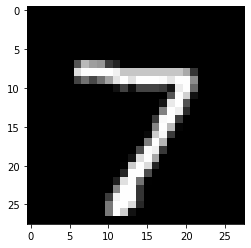

In [10]:
plt.imshow(X_test[0].reshape(28,28), cmap='gray', interpolation='none')

In [11]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

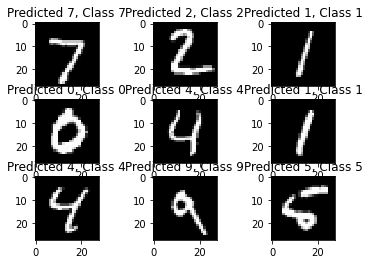

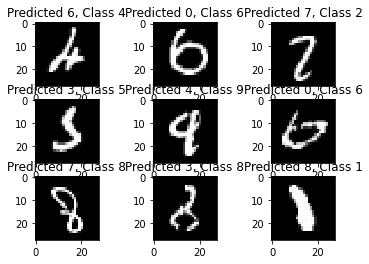

In [12]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [13]:
#ActMax
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## Visualize max activations for all digits

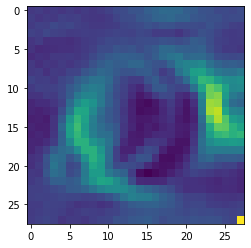

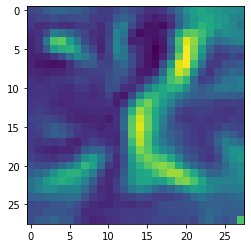

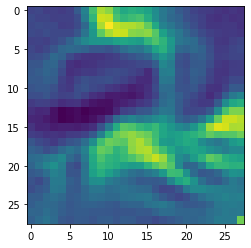

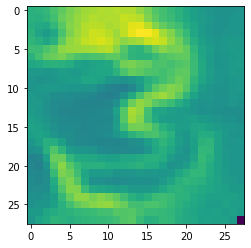

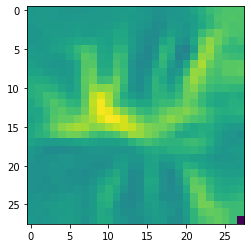

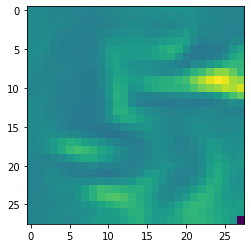

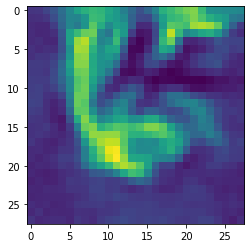

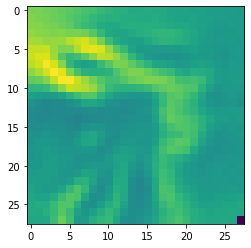

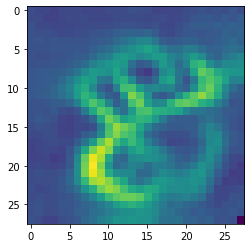

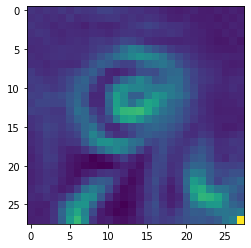

In [14]:
for digit in range(10):
    img = visualize_activation(model, layer_idx, filter_indices=digit, input_range=(0., 1.))
    plt.figure()
    plt.imshow(img[..., 0])

## Visualize activation combining multiple digits

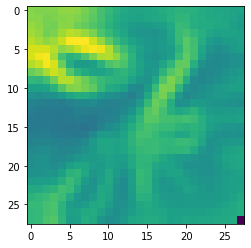

In [15]:
digit_mix = [1,7] # we want to see what the network things is both 1 and 7
img = visualize_activation(model, layer_idx, filter_indices=digit_mix, input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

